# New Run
A_02: LHY, but new normalization. 

# Sequence Learning - Direct - English
Version 1: In this version we make the model "simple": make the encoder RNN into normal RNN first and try to see the result.  
Version 2: Learning is not very much. Following Dr Coupe's advice we try simpler model structure.   
Version 3: A simple trial training with Mel spectrogram instead of MFCC.   
Version 4: try to enlarge the hidden dimensions so that we might still make sense of the hidden representation.   
Version 5: restore to MFCC, keep 8-dimensional, direct feedin.   
Version 6: This time using Wang et al. structure and hyperparams. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from datetime import datetime

In [2]:
from model import PhxLearner, SimplerPhxLearner, LHYPhxLearner
from my_dataset import DS_Tools
from dataset import SeqDataset, MFCCTransform
from paths import *
from my_utils import *
from recorder import *
from loss import *
from padding import generate_mask_from_lengths_mat, mask_it

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
BATCH_SIZE = 128

INPUT_DIM = 39
OUTPUT_DIM = 39

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.7

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = LHYPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
model

LHYPhxLearner(
  (encoder): LHYEncoder(
    (lin): LinearPack(
      (linear): Linear(in_features=39, out_features=32, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.7, inplace=False)
    )
    (rnn): LSTM(32, 8, batch_first=True)
  )
  (decoder): LHYDecoder(
    (rnn): LSTM(8, 32, batch_first=True)
    (lin): LinearPack(
      (linear): Linear(in_features=32, out_features=39, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.7, inplace=False)
    )
  )
)

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [8]:
params

9287

In [9]:
# Just for keeping records of training hists. 
# ts = "0918192113"
stop_epoch = "149"
ts = str(get_timestamp())
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)

save_valhist_name = "val_hist_{}.hst".format(ts)

In [10]:
train_losses = LossRecorder(model_save_dir + save_trainhist_name)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)

text_hist = HistRecorder(model_save_dir + save_txt_name)

In [11]:
READ = False
# READ = True

In [12]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = "PT_{}_{}_full".format(ts, stop_epoch)
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [13]:
mytrans = MFCCTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT)
ds = SeqDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)

test = False
if test: 
    use_len = int(0.1 * len(ds))
    remain_len = len(ds) - use_len

    # Randomly split the dataset into train and validation sets
    ds, remain_ds = random_split(ds, [use_len, remain_len])


if READ: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.8 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=SeqDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDataset.collate_fn)
valid_num = len(valid_loader.dataset)


In [14]:
len(train_loader)

1776

In [15]:
EPOCHS = 30
BASE = 0

In [16]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            y = x 
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            y = x    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            valid_loss += loss.item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [17]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  1.049 in Step 0
Training loss  0.922 in Step 100
Training loss  0.860 in Step 200
Training loss  0.846 in Step 300
Training loss  0.831 in Step 400
Training loss  0.829 in Step 500
Training loss  0.823 in Step 600
Training loss  0.820 in Step 700
Training loss  0.818 in Step 800
Training loss  0.815 in Step 900
Training loss  0.814 in Step 1000
Training loss  0.817 in Step 1100
Training loss  0.816 in Step 1200
Training loss  0.813 in Step 1300
Training loss  0.811 in Step 1400
Training loss  0.816 in Step 1500
Training loss  0.813 in Step 1600
Training loss  0.819 in Step 1700
※※※Training loss  0.833※※※
Training timepoint saved
Valid loss  0.642 in Step 0
Valid loss  0.645 in Step 50
Valid loss  0.637 in Step 100
Valid loss  0.638 in Step 150
Valid loss  0.637 in Step 200
Valid loss  0.637 in Step 250
Valid loss  0.635 in Step 300
Valid loss  0.638 in Step 350
Valid loss  0.637 in Step 400
※※※Valid loss  0.639※※※
Epoch 1
Training loss  0.815 in Step 0
Training l

KeyboardInterrupt: 

In [18]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

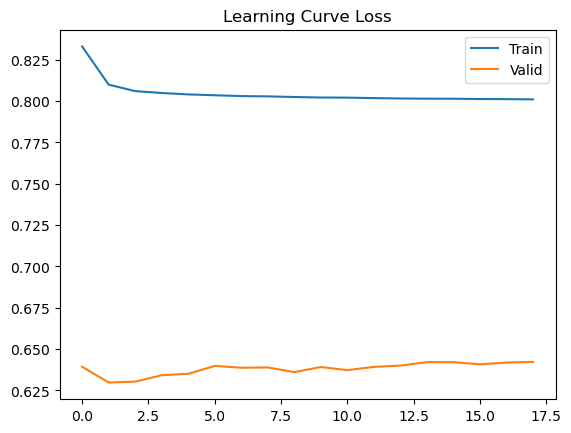

In [19]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()

## Conclusion
This model should converge to loss around 0.49x. 